In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read();return HTML(styles)
css_styling()


<figure>
<IMG SRC="images/PhysicsLogo.jpg" WIDTH=100 ALIGN="right">
</figure>
# [Physics 411](http://jklymak.github.io/Phy411/) Time Series Analysis
*Jody Klymak*


# Week 7: Filtering

<figure>
<IMG SRC="./images/Passband.jpg" WIDTH=300 ALIGN="right" STYLE="padding-left:20px" ALT="Turbulence and internal wave spectra in the ocean">
</figure>

It is often useful to filter time-series either to remove noise or to remove a strong  signal we are not interested in.  There are two tradeoffs with filtering: 1) how quickly the filter rolls off in frequency space, and 2) how naturally it responds in time space, including both "ringing" and phase shifts.

There are two types of filters in the time domain: linear filters and  recursive  (or autoregressive) filters.   It is also possible to filter in the frequency domain by taking the fft, removing the frequencies you do not want, and then running the inverse fft.

There is a lot of history to running filters, in particular because they often have analog electronic counterparts (you may have used a [RC filter](http://en.wikipedia.org/wiki/RC_circuit) in Phy 214 to filter high-frequency noise).  Here we won't concern ourselves too much with the more analytical aspects of filter design, and focus on the practicalities in choosing a good filter for data analysis purposes.

## Filtering terminology

There are a few terms used when discussing filtering, some of which are in common with Linear Systems from the last lecture. We talk about the filter's frequency response, we are talking about its impulse response characteristics in the frequency domain, and below we will call this $H(f)$, or $H_m=H(f_m)$ for the discrete time series.  For a **low-pass** filter we would ideally like the frequency response to be unity at low frequencies and zero at high frequencies.  In the picture above, the ideal response is sketched in grey as a step function at $f/f_c=1$, and the impulse response is called the **gain**.  

The region to the left of $f/f_c=1$ is called the **passband**, and the region to the right is called the **stopband**.  The ripples pictured above in the *passband* are called **passband ripples**, and are present in most filters to an extent.  The *stopband* usually only has a finite rate at which the *gain* rolls off.  This is can be expressed as a **stopband attenuation factor**, or an acceptable level of gain at some frequency above $f/f_c=1$.

Engineers love decibels, so the *passband ripple* and *stopband attenutaion factor* are often expressed as decibles. If we don't want the *passband ripple* to be more than $0.02$, then we would say no more than $20\mathrm{log_{10}}(1.02)=.17 \mathrm{dB}$ of *passband ripple*.  Similarly, if we wanted the stopband to be no more than 2% of the passband, then we would specify that the amplitude is $20\mathrm{log_{10}}(.02) =-34 \mathrm{dB}$ at some frequency.

## Filtering time domain: Finite impulse response filters

As an example, lets make a synthetic time series consisting of a localized sine wave at one frequency and a weak red-noise process. Then we add a large amount of white-noise over top which represnets measurement noise.  We'd like to be able to filter the data to return the signal (black line) and remove as much of the (white) noise as possible.

<IPython.core.display.Javascript object>


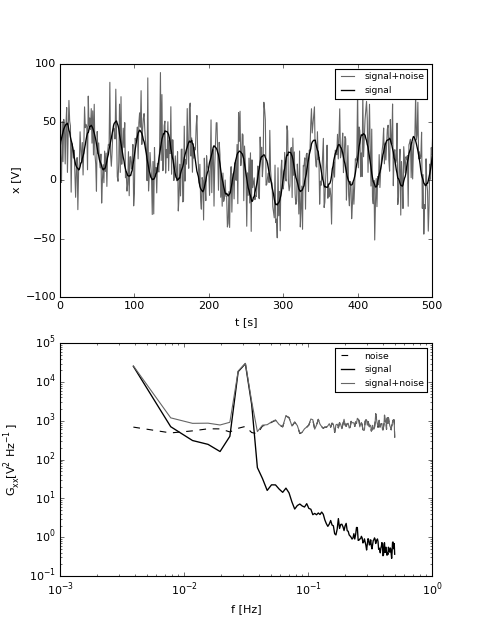

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib nbagg

N=256*10
dt=1.
t=np.arange(0,N*dt,dt)
x = np.cumsum(np.random.randn(N)) # red noise
f0=0.03 # Hz
x = x+ 20.*np.sin(f0*2*np.pi*t) # + sine wave
x=x-np.mean(x)
noise = 20.*np.random.randn(N)
xn = x+noise
# remove the mean!!
xn = xn-np.mean(xn)
nfft=128*2
args = {'NFFT':nfft,'Fs':1./dt,'noverlap':nfft/2.,'window':mlab.window_hanning}
px,f=mlab.psd(x,**args)
pn,f = mlab.psd(noise,**args)
fig,ax=plt.subplots(2,1,figsize=(6,8))
ax[0].plot(t,xn,color="0.4",label="signal+noise")
ax[0].plot(t,x,'k',linewidth=1.2,label="signal")
ax[0].set_xlim((0,500));ax[0].legend(fontsize='small');ax[0].set_xlabel('t [s]');ax[0].set_ylabel('x [V]')
# spectrum
ax[1].loglog(f,pn,'k--',label="noise");
ax[1].loglog(f,px,'k',linewidth=1.2,label="signal")
ax[1].loglog(f,px+pn,color="0.4",label="signal+noise")
ax[1].set_xlabel('f [Hz]');ax[1].set_ylabel(r'$G_{xx} \mathrm{[V^2 Hz^{-1}]}$');ax[1].legend(fontsize='small')

The most naive filter is the boxcar filter, or a moving average.  For that, we choose a filter length that will keep the peak, but will remove most of the noise.  For the example above, the peak is burried in the noise at $f=0.03\ \mathrm{Hz}$, so we might want a boxcar that is 25-s long, or for this 1-Hz data 25 data points long. This would put an ideal filter at  $f=0.04\ \mathrm{Hz}$, or just above our peak. Lets see the effect of applying that:
$$ y_n = \sum_{k=0}^{24} \frac{1}{25}x_{n+k} $$

<IPython.core.display.Javascript object>


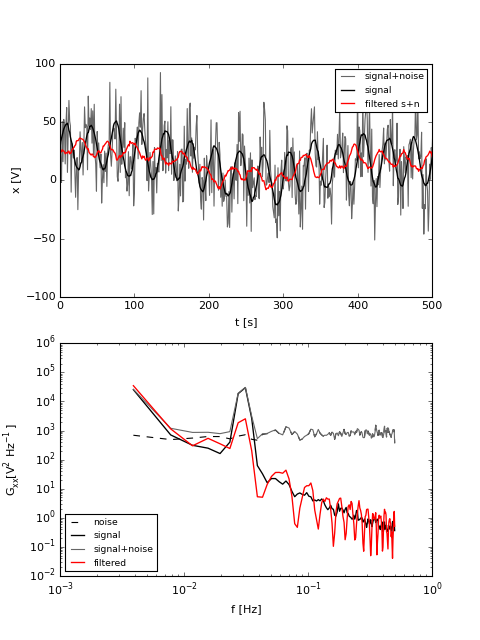

(<matplotlib.figure.Figure at 0x10f32d450>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1104a6b50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1107c0690>], dtype=object))

In [32]:
y=0.*xn
# do the running average:
for n in range(0,N-1,1):
    y[n]=sum(xn[n:(n+25)])/25.
py,f = mlab.psd(y,NFFT=nfft,Fs=1./dt)
def plotxyn(nosec=False):
    fig,ax=plt.subplots(2,1,figsize=(6,8))
    ax[0].plot(t,xn,color="0.4",label="signal+noise")
    ax[0].plot(t,x,'k',linewidth=1.2,label="signal")
    ax[0].plot(t,y,'r',linewidth=1.2,label="filtered s+n")
    ax[0].set_xlim((0,500))
    ax[0].legend(fontsize='small')
    ax[0].set_xlabel('t [s]')
    ax[0].set_ylabel('x [V]')
    # spectrum
    if nosec:
        return
    ax[1].loglog(f,pn,'k--',label="noise")
    ax[1].loglog(f,px,'k',linewidth=1.2,label="signal")
    ax[1].loglog(f,px+pn,color="0.4",label="signal+noise")
    ax[1].loglog(f,py,'r',linewidth=1.2,label="filtered")
    ax[1].set_xlabel('f [Hz]')
    ax[1].set_ylabel(r'$G_{xx} \mathrm{[V^2 Hz^{-1}]}$')
    ax[1].legend(fontsize='small')
    ax[1].set_ylim((1.e-2,10.e5))
    ax[1].legend(loc=3,fontsize='small')
    return fig,ax
plotxyn()

So, that was a reasonable guess.  Certainly the low-frequencies are better resolved.  But, it really attenuated the sine-wave. The sine wave also looks like its suffered a phase shift, which we may have expected from the fact that $y_1$ is the sum of $x_1$ to $x_{25}$.

We can emperically consider just the filter response by noting that $y=h*x$, so the Fourier transform is given by $Y(f)=H(f)X(f)$, and the filtering is just a linear system. Then emperically, $|H(f)|=\sqrt{G_{yy}/G_{xx}}$, and we get the phase of the filter from noting that:

$$X^*(f)Y(f) = H(f) X^*(f)X(f)$$

Or $angle(H(f)) = angle(G_{xy})$

<IPython.core.display.Javascript object>


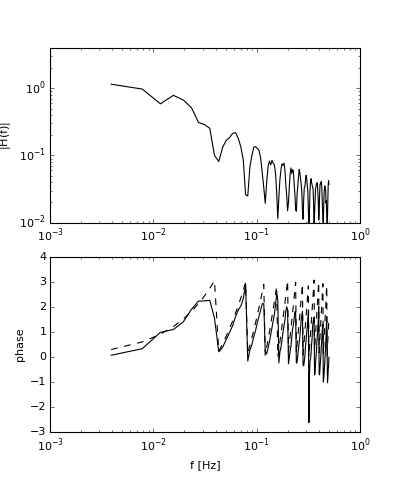

(<matplotlib.figure.Figure at 0x10e549590>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11259b610>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x112819d50>], dtype=object))

In [33]:
Gxy,f  = mlab.csd(xn,y,Fs=1./dt,NFFT=nfft)
def plotit():
    fig,ax=plt.subplots(2,1,figsize=(5,6))

    ax[0].loglog(f,np.sqrt(py/(px+pn)),'k')
    ax[0].set_ylim((1.e-2,4))
    ax[0].set_ylabel(r'$|H(f)|$')

    ax[1].semilogx(f,np.angle(Gxy),'k')

    ax[1].semilogx(f,np.mod(2*np.pi*f*25./2.,np.pi),'k--')
    ax[1].set_ylabel('phase')
    ax[1].set_xlabel('f [Hz]')
    return fig,ax
plotit()

We can compute the frequency response of $H_m=H(f_m)$ where $f_m = \frac{m}{N}$ by taking the discrete Fourier transform of $h_k$:

\begin{align}
    H_m =& \frac{T}{N}\sum_{k=0}^{K-1} h_k \mathrm{e}^{\frac{-j2\pi km}{N}}
\end{align}, where $K$ is the length of the filter.  

For the boxcar, $h_k=1/K$, so 

\begin{align}
    H_m =& \frac{T}{KN}\sum_{k=0}^{K-1} \mathrm{e}^{\frac{-j2\pi km}{N}}
\end{align}

This is  just a [geometric series](http://mathworld.wolfram.com/GeometricSeries.html), for which

$$ \sum_{k=0}^{K-1} r^k = \frac{1-r^K}{1-r}$$

so 

\begin{align}
    H_m =& \frac{T}{KN} \frac{1- \mathrm{e}^{\frac{-j2\pi Km}{N}}}{{1- \mathrm{e}^{\frac{-j2\pi m}{N}}}}\\
    =& \frac{T}{KN}\mathrm{e}^{\frac{-j2\pi (K-1)m}{N}} \frac{\sin\left(\pi mK/N\right)}{\sin\left(\pi m/N\right)}
\end{align}

This is called the [Dirichlet Kernel](http://en.wikipedia.org/wiki/Dirichlet_kernel), and is a fundamental function of time series analysis.  It looks just like the sinc function for the continuous Fourier transform of a rectangle function discussed previously.  

Applied to $K=25$ it looks like:


<IPython.core.display.Javascript object>


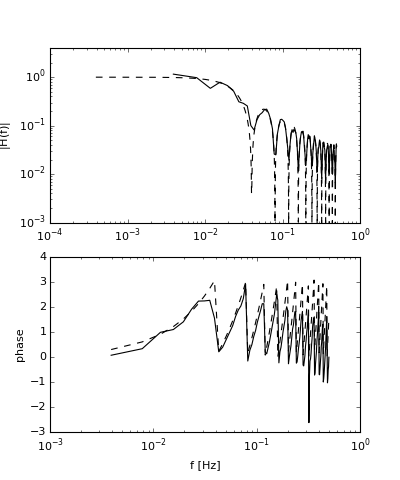

(0.001, 4.0)

In [34]:
m = np.array(range(1,N/2))
K=25.
H = 1./K*np.sin(np.pi*m*K/N)/np.sin(np.pi*m/N)

fm = m/dt/(1.*N)
# redo the last plot
fig,ax=plotit()
ax[0].loglog(fm,abs(H),'k--')
ax[0].set_ylim((1e-3,4.))


Note that the complex part of the **filter response function** $H_m$ leads to a linear phase offset as a function of frequency.  

Here we see that the theoretical response is echoed in the filtered data response as we might expect.  

This response has two problems: 

    1. There is significant "leakage" to high frequencies
    2. There is a significant phase shift.
    
The phase shift is actually less of a problem than it appears.  We could redefine our filter to be properly centered on the data, and the phase shift would go away.  The poor high-frequency roll off is fixed the same way we fixed it when we fixed leakage in the Fourier transform: by applying a suitably tailored filter that the has better roll-off characteristics.

#### Carrying on with example###

The passband is clearly lower than our hoped-for 0.04 Hz.  In fact that is the first null of the filter.  We also note a phase offset that looks very regular.  In fact it can be shown that a phase offset of $\phi = \delta t (2\pi f)$ is expected, where $\delta t$ in this case is 25/2= 12.5 s.  This phase offset can easily be removed by centering the filter on the data.  

Also, a better filter for keeping the peak would be closer to 12 samples.  We'll choose 13 samples to make a symmetric filter.  While we are at it, lets center the filter.

[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]


<IPython.core.display.Javascript object>


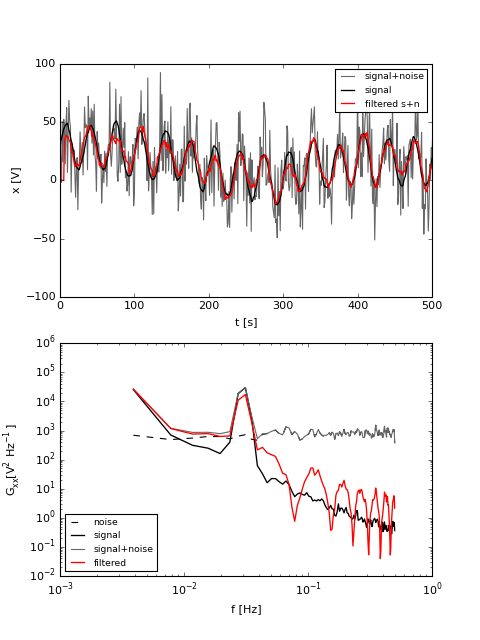

(<matplotlib.figure.Figure at 0x1120bc790>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x113454a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11349b590>], dtype=object))

In [35]:
y=0.*xn
filtl=12 #+1
ind = np.array(range(-filtl/2,filtl/2+1))
print ind
for n in range(filtl/2,N-filtl/2,1):
    y[n]=np.sum(xn[n-ind])/(1.*filtl+1)
py,f = mlab.psd(y,**args)
plotxyn()

Centering gets rid of the phase lag (as you might expect), and the better choice of frequency allows more of the sinusoid to come through, though there is still some attenuation.  

## Simple  filter in frequency space

So, the boxcar in time is non-ideal: it rolls off quite slowly in frequency space and doesn't squelch the high frequencies as well as we might like.  How about another approach, filtering in frequency space?  Here we simply calculate the Fourier transform of $x(t)$, remove the frequencies with $f>0.04 Hz$, and then do an inverse Fourier transform:

1.0
256


<IPython.core.display.Javascript object>


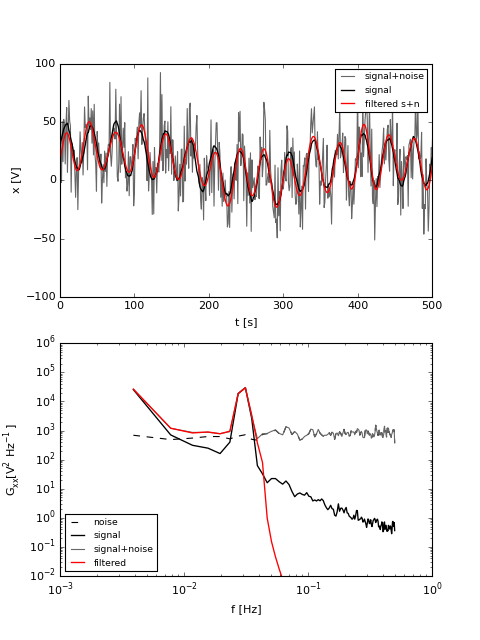

(<matplotlib.figure.Figure at 0x112e20550>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x10e7a49d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x114074f90>], dtype=object))

In [37]:
X = np.fft.fft(xn)

N = np.shape(xn)[0]
print dt
print nfft
ff = np.linspace(0,1./dt,N)
# Note that because the FFT is symetric we have to mask some of the high frequencies as well
X[(ff>0.04) & (ff<(1./dt-0.04))]=1.e-15
y = np.real(np.fft.ifft(X))+np.mean(xn)
py,fff = mlab.psd(y,**args)
xn0=xn*1.0
x0=x*1.0
plotxyn()

So, this works pretty well for this time series, though we can see there are some parts of the signal that are not precisely followed.  So why not filter exactly like this?  For the same reason it doesn't work well to filter with a boxcar in the time domain.  Consider a sharp step in our time series:

1.0
256


<IPython.core.display.Javascript object>


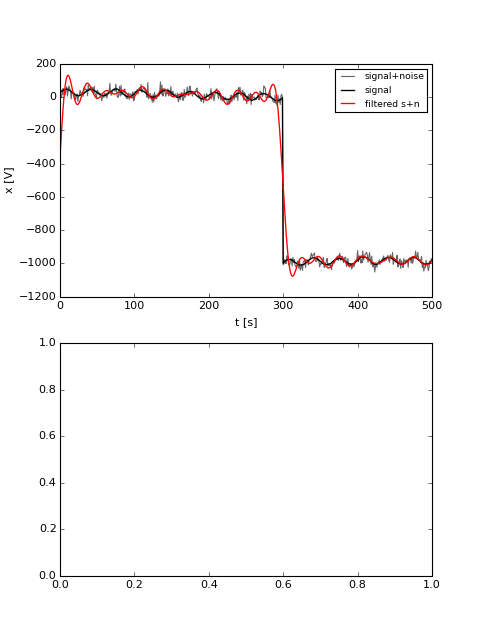

In [39]:
xn=1.0*xn0
x = 1.0*x0
# put s sudden jump in
xn[300:-1]=xn[300:-1]-1000.
x[300:-1]=x[300:-1]-1000.
X = np.fft.fft(xn)
N = np.shape(xn)[0]
print dt
print nfft
ff = np.linspace(0,1./dt,N)
# Note that because the FFT is symetric we have to mask some of the high frequencies as well
X[(ff>0.04) & (ff<(1./dt-0.04))]=1.e-15
# There is a strange bug in psd that makes adding this little bit of noise necessary.
y = np.real(np.fft.ifft(X))+1.e-17*np.random.randn(N)

py,fff = mlab.psd(y,**args)

plotxyn(nosec=True)


Note the sharp overshoot at the step.  This is "ringing" or "ripple" is due to the overly sharp frequency filter.  Again, the solution is to window in frequency space (see exercise).

## Filter design: Finite amplitude response (FIR)

If the Boxcar is too crude for our needs, then we need to design something more sophisticated.  The simplest idea is to consider a boxcar in frequency space: $H_m = 1$, for $|m| \lt (M-1)/2$, $H_m=0, |m| \gt (M-1)/2$. Here, $(M-1)/2 = f_c T$ is the integer representing $f_M>=f_c$, our design cutoff.   This gives us a Dirichlet Kernel in the time domain:

$$h_k = \frac{1}{N}\frac{\sin(\pi k M/N)}{\sin(\pi k/N)} $$

Note that here the phase information in the kernel has been ignored, except for the plus or minus due to the sin.  Thus we already can predict a problem with this style of filter: that it will not have the phase information correct.  

Choosing some numbers, imagine the time series is $N=161$ data points long, each sampled $\delta t=1 \mathrm{s}$ apart and we want to filter at 0.1 Hz.  Then $M = 2 f_c T +1=2 f_c/f_S N=31$.
Plotting it in time and frequency:

<IPython.core.display.Javascript object>


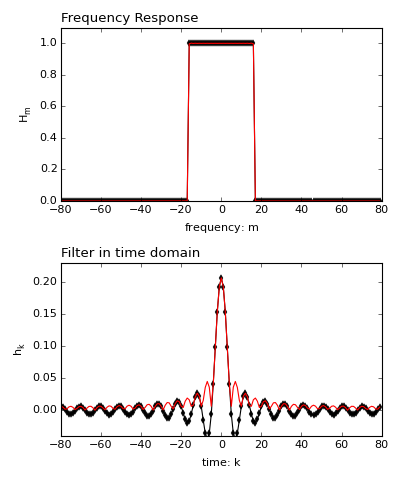

In [48]:
N=161
fs=1.
fc = 0.1/fs

M = fc*2*N+1
k = np.array(range(-N/2+1,N/2))
m= k*1.
H = 0.*k+1.
H[(np.abs(m)>(M)/2)]=0.
H1=H
## Note the use off fftshift.  Usually fft and ifft assume that k=0 
# is the first element in the vector, and k=N is the last.  
# fftshift puts k=-N/2 as the first, and k=+N/2-1 as the last.
h1 = np.abs(np.fft.fftshift(np.fft.ifft(np.fft.fftshift(H))))
# trick!  the Dirichlet kernal has singularities at integer values of k, 
# so we add very small numbers to k get rid of these:
h2 = (1./N)*np.sin(np.pi*(k+0.000001)*M/N)/np.sin(np.pi*(k+0.000001)/N)
H2 = np.fft.fftshift(np.fft.fft(h2))
fig,ax=plt.subplots(2,1,figsize=(5,6))
ax[0].plot(m,H,'dk',markersize=4)
ax[0].plot(m,H,'k')

ax[0].plot(m,abs(H2),'r')
ax[0].set_ylim((0,1.1))
ax[0].set_ylabel(r'$H_m$')
ax[0].set_xlabel(r'frequency: $m$');ax[0].set_title('Frequency Response',loc='left')
#xlim((-20,20))
ax[1].plot(k,h2,'dk',markersize=4)
ax[1].plot(k,h2,'k',label='Dirchlet kernel')
ax[1].plot(k,h1,'r',label='Inverse fft of step function')
ax[1].set_title('Filter in time domain',loc='left')
plt.ylabel(r'$h_k$')
plt.xlabel(r'time: $k$')
plt.ylim([-0.04,0.23])
plt.tight_layout()

Note that both the frequency and the time response have length $N=161$. (Also note the use of `fftshift` to return vectors centered on zero.)

The ideal filter in the frequency domain (index $m$) is the Dirichlet kernel in the space domain (index $k$).  However, we cannot filter with this raw $h_k$ because it has length $N$, and that is how long our time series is! So we have to truncate $h_k$, and that of course leads to imperfections in the frequency domain. 

Consider the case where the length of the time series is $N=161$, and lets look at the effect of truncating the filter $h_k$ to have 101, 31, 19, 11 and 5 elements:

<IPython.core.display.Javascript object>


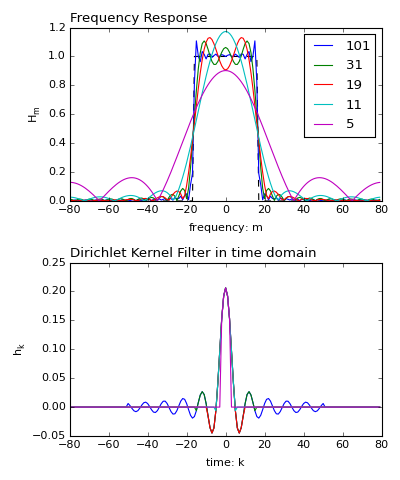

In [51]:
N=161

M = fc*2*N+1
h2 = (1./N)*np.sin(np.pi*(k+0.000001)*M/N)/np.sin(np.pi*(k+0.000001)/N)
k = np.array(range(-N/2+1,N/2))

H1 = h2*0+1.
H1[abs(k)>(M-1)/2]=0.
fig,ax=plt.subplots(2,1,figsize=(5,6))
ax[0].plot(k,H1,'k--')
for K in [101,31, 19, 11, 5]:
    h = h2
    h[abs(k)>(K-1)/2]=0
    H = N*np.fft.fftshift(np.fft.ifft(h))
    

    ax[0].plot(k,abs(H),label='%d' % K)
    ax[1].plot(k,h)
ax[0].legend()
ax[1].set_ylabel(r'$h_k$');ax[1].set_xlabel(r'time: $k$');ax[0].set_title('Frequency Response',loc='left')
ax[0].set_ylabel(r'$H_m$');ax[0].set_xlabel(r'frequency: $m$');ax[1].set_title('Dirichlet Kernel Filter in time domain',loc='left')

plt.tight_layout()

As the truncated Dirichlet kernel gets smaller, the *roll-off* gets less steep and the *passband ripple* size gets larger.  Even for a kernel with 101 entries, there is a substantial ripple at the edges of the passband, an effect that is often un-desireable.
There is usually a trade-off in designing FIR filters between the amplitude of the *passband ripple* and the sharpness of the *roll-off*.  

One approach to reducing the ripple is to window the truncated dirichlet kernel.  If $h_k^K$ is the Dirichlet kernel of length $K$, then we choose the Hanning window of length $K$ to smooth out the passband ripple and form a new filter: $h'_k=h_k^K w^K$:

<IPython.core.display.Javascript object>


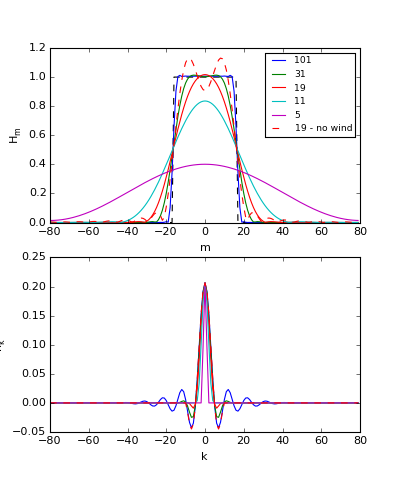

In [58]:
h2 = (1./N)*np.sin(np.pi*(k+0.000001)*M/N)/np.sin(np.pi*(k+0.000001)/N)
H1 = h2*0+1.
H1[abs(k)>(M-1)/2]=0.
fig,ax=plt.subplots(2,1,figsize=(5,6))
ax[0].plot(k,H1,'k--')
for K in [101,31, 19, 11, 5]:
    h = 1.0*h2
    h[abs(k)>(K-1)/2]=0
    w = 0.*h
    w[abs(k)<=(K-1)/2]=np.hanning(K)
    H = N*np.fft.fftshift(np.fft.ifft(h*w))
    ax[0].plot(k,abs(H),label='%d' % K)
    ax[0].set_xlabel('m ')
    ax[0].set_ylabel('$H_m$')
    ax[1].plot(k,h*w)
            
    ax[1].set_xlabel('k')
    ax[1].set_ylabel('$h_k$')
K=19
h = 1.0*h2
h[abs(k)>9]=0  
H = N*np.fft.fftshift(np.fft.ifft(h))
ax[0].plot(k,abs(H),'r--',label='19 - no wind')
ax[0].legend(fontsize='small')
ax[1].plot(k,h,'r--')

Comparing the windowed version for $K=19$ (red solid line) to the un-windowed filter (red dashed line), we see that the roll-off suffers, but the ripple is greatly reduced.  There is no free lunch in filter design!

### Example Truncated Dirichlet Kernel Filter

<IPython.core.display.Javascript object>


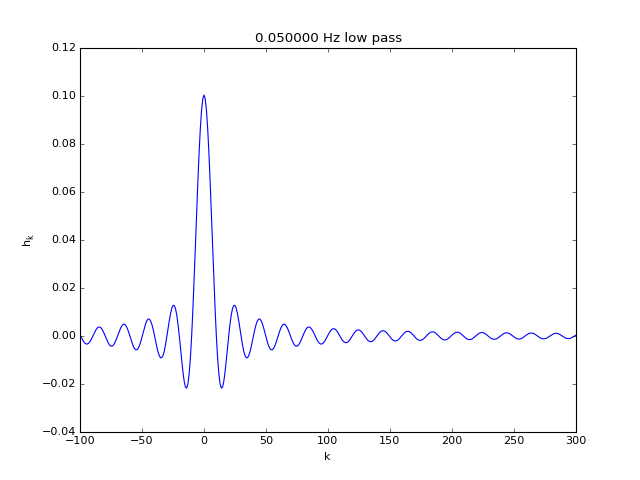

In [64]:
# redoing our example:
N=256*10
dt=1.
t=np.arange(0,N*dt,dt)
x = np.cumsum(np.random.randn(N)) # red noise
f0=0.03 # Hz
x = x+ 20.*np.sin(f0*2*np.pi*t) # + sine wave
x=x-np.mean(x)
noise = 20.*np.random.randn(N)
xn = x+noise
# remove the mean!!
xn = xn-np.mean(xn)
#
# Calculating the truncated Dirichlet Kernel to filter at 0.05 Hz lowpass:
k = np.array(range(-N/2+1,N/2))
fc = 0.05
M = fc*2*N+1
h2 = (1./N)*np.sin(np.pi*(k+0.000001)*M/N)/np.sin(np.pi*(k+0.000001)/N)
fig,ax=plt.subplots(1,1)
ax.plot(k,h2)
ax.set_xlabel('k')
ax.set_ylabel('$h_k$')
ax.set_xlim([-100,300])
ax.set_title('%f Hz low pass'%fc)

So, to get a 0.05 Hz low-pass we will need a filter that is at least 40 points wide;  lets use 120:

<IPython.core.display.Javascript object>


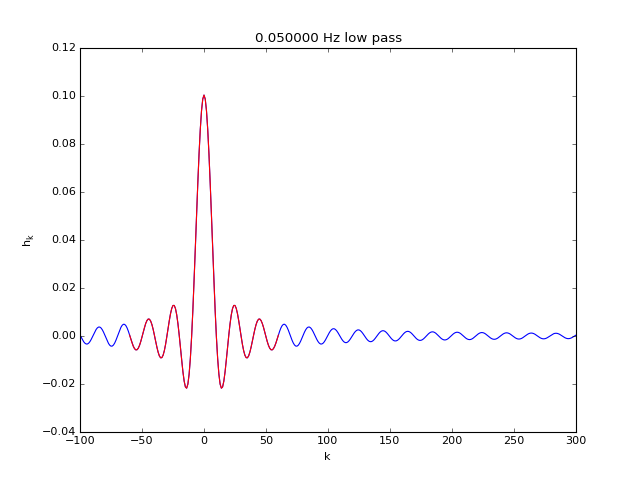

In [66]:
h = h2*1.
# how long is the filter:
filtlen=60
h = h[abs(k)<filtlen+1]
fig,ax=plt.subplots(1,1)
ax.plot(k,h2)
ax.set_xlabel('k')
ax.set_ylabel('$h_k$')
ax.set_xlim([-100,300])
ax.set_title('%f Hz low pass'%fc)
ax.plot(k[abs(k)<filtlen+1],h,'r')


<IPython.core.display.Javascript object>


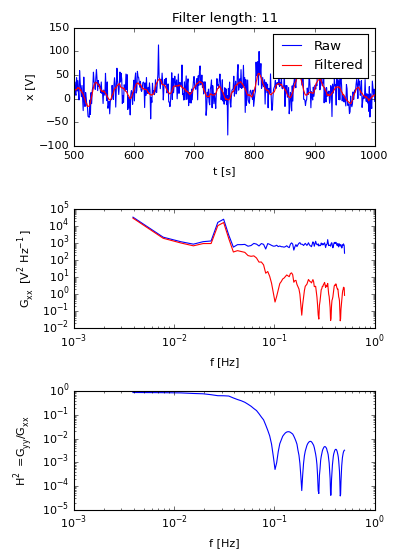

<IPython.core.display.Javascript object>


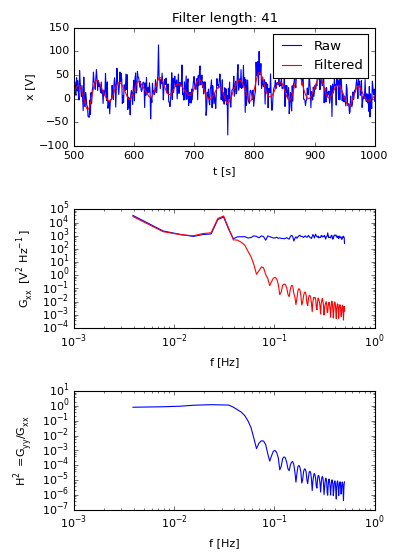

<IPython.core.display.Javascript object>


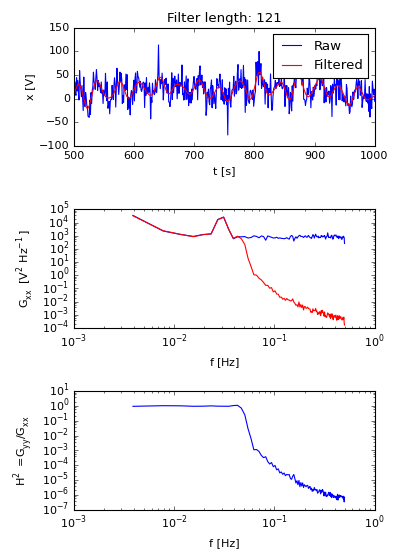

In [67]:
# now filter and plot for a number of values of filtlen

for filtlen in [5,20,60]:
    h = h2*1.
    # how long is the filter:
    h = h[abs(k)<filtlen+1]
  
    # now filter
    y = np.convolve(xn,h,mode='same')
    fig,ax=plt.subplots(3,1,figsize=(5,7))
    ax[0].plot(xn,label='Raw')
    ax[0].plot(y,label='Filtered',color='r')
    ax[0].set_xlim([500,1000])
    ax[0].set_xlabel('t [s]');ax[0].set_ylabel('x [V]');ax[0].legend()
    nfft=256
    pxx,f=mlab.psd(xn,Fs=1.,NFFT=nfft,noverlap=nfft/2)
    ax[1].loglog(f,pxx)
    pyy,f=mlab.psd(y,Fs=1.,NFFT=nfft,noverlap=nfft/2)
    ax[1].loglog(f,pyy,color='r')
    ax[1].set_ylabel('$G_{xx}\ \ [V^2 Hz^{-1}]$')
    ax[1].set_xlabel('$f\ [Hz]$')
    ax[2].loglog(f,pyy/pxx)
    ax[2].set_ylabel('$H^2 = G_{yy}/G_{xx}$')
    ax[2].set_xlabel('f [Hz]')
    ax[0].set_title('Filter length: %d'%(2*filtlen+1))
    plt.tight_layout()

So we see that as the filter length gets longer the filter resonse gets better, though even the short filter (length=11) does OK, with only a slight attenuation at lower frequencies.  When choosing filters, it is good practice to test them to see what changes they make to the data and response.

### Other FIR filters

Considerable effort has gone into designing filters like this.  The Chebyshev and Kaiser filters in particular allow the tradeoff of transition to ripples in the passband to be explicitly dealt with.  The Chebyshev Filter allows us to specify precisely the height of the sidelobes in the stopband by specifying a parameter $\gamma$, where the side lobe attenuation in decibels is 

$$Atten_{Cheb} = -20 \gamma$$

So, if we wanted the first sidelobe at -60 dB, we'd choose $\gamma=3$.  

The Chebyshev function is given by the inverse DFT of 

$$ \frac{\cos \left( N \ \cos^{-1}\left(\alpha\cos\left(\pi m/N\right) \right)\right)}{\cosh\left(N\ \cosh^{-1}(\alpha)\right)} $$

where $\alpha = \cosh\left(\frac{1}{N} \cosh^{-1}\left(10^\gamma\right)\right)$ and $m=0,1,...,N$.

Thats kind of complicated. Fortunately, most packages provide a Chebyshev filter function.  In matlab it is `cheby1`, and in python it is as below:

<IPython.core.display.Javascript object>


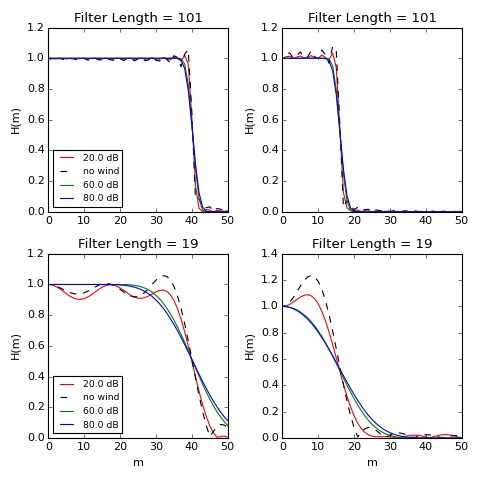

In [72]:
from scipy.signal import firwin

N=161

h2 = np.zeros(N)
k = np.array(range(-N/2+1,N/2+1))
num=0
col=['r','g','b']

fig,ax=plt.subplots(2,2,figsize=(6,6))
for ii,len_ in enumerate([101, 19]):
    for jj,ws in enumerate([0.25, 0.1]):
        # 0.25 is similar to a 4-sample smoothing
        # 0.05 is 20-samples.  
        num=num+1
        
        nn=0
        for atten in [20,60,80]:
            nn=nn+1
            w = firwin(len_,ws,window=("chebwin",atten),nyq=0.5)

            w2 = firwin(len_,ws,window=("boxcar"),nyq=0.5)
            h = h2*0.
            h[N/2]=1.0
            h[abs(k)<(len_-1)/2+1] = w
            H = np.fft.fftshift(np.fft.fft(h))

            h[abs(k)<(len_-1)/2+1] = w2
            H2 = np.fft.fftshift(np.fft.fft(h))
            ax[ii,jj].plot(k,abs(H),color=col[nn-1],label='%1.1f dB' % atten)
            if nn==1:
                ax[ii,jj].plot(k,abs(H2),'k--',label='no wind')
            ax[ii,jj].set_xlim((0,50))
        if (num==1) or (num==3):
            ax[ii,jj].legend(loc=3,fontsize='small')
        if num>2:
            ax[ii,jj].set_xlabel('m')
        ax[ii,jj].set_ylabel('H(m)')
        ax[ii,jj].set_title('Filter Length = %d' % len_)   
plt.tight_layout()

The parameter `atten` is the attenuation in db of the passband ripple.  

The tradeoffs are similar to the Hanning window above:

  1. More filter co-efficients makes for a better filter, but effects at the edge of your time series are larger.
  2. More ripple suppresion (larger values of `atten`) leads to slower roll-off. 
  
There are lots of other windows that can be applied to create FIR filters.  The biggest thing to note is that as the filter length gets small compared to f_s/f_c, then the filtering will not be good, no matter what.  i.e. if our sampling frequency is 1 Hz, and $f_c=0.1 Hz$, a filter of length less than 21 or so is not going to be very useful.   That can be seen in the last plot above, and should be intuitively obvious - the window has to be at least as wide as the period of the frequency you want to filter.

## Recursive Filters: Infinite impulse response (IIR)

IIR filters allow recursion i.e. the result at given filtered sample depends not only on the current and past raw samples, but on the past filter results.  This has the very large *advantage* of making for very compact filters, even if we are filtering low frequencies.  The *disadvantage* is that the filters are more complicated to design, and in some cases can lead to singularities where the filter causes the filtered signal to go to infinity.  

The usual way to write the recursion out is:

$$a_0 y_n = \sum_{m=0}^M b_m x_{n-m} - \sum_{k=1}^K a_k y_{n-k} $$

where the $b_m$ are the filter co-efficients for the past and current raw data, and $a_k$ are the co-efficients fro the past filtered data. (Note the particular form has been chosen to be consistent with the conventions used by Matlab and Python.  Make sure any package you use has the same signs for the co-efficients).  The frequency response of this filter is given by:

$$H(f) = \frac{\sum_{m=0}^M \frac{b_m}{a_0} e^{-j 2\pi m f \Delta t} }{1 + \sum_{k=1}^K \frac{a_k}{a_0} e^{-j 2\pi k f \Delta t}} $$
Note that if $a_k=0$ for $k>0$, then this is just an FIR filter.

As we will see below, it is convenient to define a complex variable $z =  e^{+j 2\pi  f \Delta t}$, so we can rewrite

$$H(f) = \frac{\sum_{m=0}^M \frac{b_m}{a_0} z^{-m} }{1 + \sum_{k=1}^K \frac{a_k}{a_0} z^{-k} } $$

The goal of IIR filter design is to choose the filter co-efficients so that $H(f)$ looks the way we would like.  This becomes pretty arcane, and is related to analog filter design, which is the reason for the above "z-transform".

### A simple design technique

This discussion follows from [Numerical Recipes](http://apps.nrbook.com/empanel/index.html#), section 13.5.3 (Third Edition; its chapter 12 in older editions) .  If we make a second transform that maps the frequencies $f$ into an infinite domain: 

$$w=\tan(\pi f \Delta t) = j\frac{(1-z)}{(1+z)} $$

Then the trick is to express $|H(f)|^2$ as rational functions of $w^2$.  If we do this, then we can express it in terms of the filter co-efficients after some algebra.  For a simple example, consider

$$|H(f)|^2 = \frac{B^2}{w^2 + B^2} $$

where $B = \tan(\pi f_c \Delta t)$, and $f_c$ is a desired cutoff frequency.  As $w$ approaches infinity, $|H(f)|^2$ approaches zero, and as $w$ approaches 0, the gain of the response approaches 1.  Between, it is a pretty poor filter, but its an easy example:

<IPython.core.display.Javascript object>


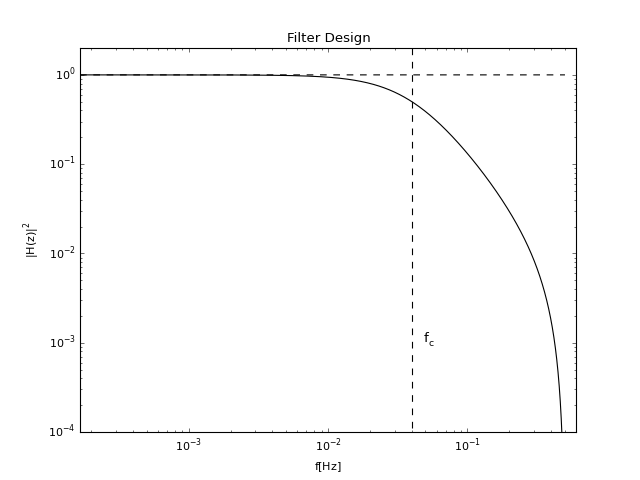

In [78]:
N=3000
dt=1.
t=np.arange(0,N*dt,dt)
f=np.linspace(-1/dt/2.+1/N/dt,1/dt/2.,N)
ff=f
w = np.tan(np.pi*f*dt)
fc=0.04
B = np.tan(np.pi*fc*dt)
H = B**2/(w**2+B**2)
fig,ax=plt.subplots(1,1)
ax.loglog(f,H,'k')
ax.loglog(f,H*0. + 1.,'k--')
ax.plot(np.array([1.,1.])*fc,[2, 1e-4],'k--')
ax.text(fc,1e-3,r'$ \ \ \   f_c$',fontsize=12)
ax.set_xlim((0,0.6));ax.set_ylim((1e-4,2))
ax.set_xlabel(r'$f [Hz]$');ax.set_ylabel(r'$|H(z)|^2$');ax.set_title('Filter Design')

To implement the filter, we note that we can write $H(f)$ as a function:
$$ H(f) = \frac{j B}{w-jB}$$
substituting for $z$
$$ H(f) = \frac{B}{\frac{1-z}{1+z}-B}$$
and we then rewrite as inverse powers of $z$:
$$ H(f) = \frac{B}{\frac{1/z-1}{1/z+1}-B}$$

$$ H(f) = \frac{B + B z^{-1}}{(-B-1) + (1-B)z^{-1}}$$

So, comparing to $$H(f) = \frac{\sum_{m=0}^M \frac{b_m}{a_0} z^{-m} }{1 + \sum_{k=1}^K \frac{a_k}{a_0} z^{-k} } $$

This corresponds to $b_i = [B, B]$ and $a_i = [-B-1, 1-B]$, which we will consider below:

<IPython.core.display.Javascript object>


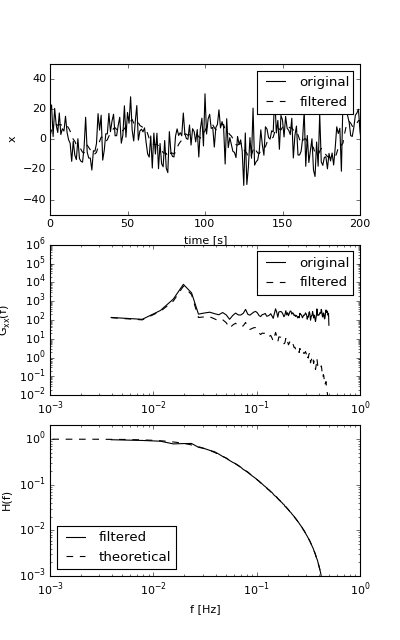

In [81]:
import scipy.signal as signal

N=3000
dt=1.
t=np.arange(0,N*dt,dt)
x = 10*(np.random.randn(N)) # white noise
f0=2e-2 # sine wave freqeuncy
fc=0.04 # filter cutoff frequency
B = np.tan(np.pi*fc*dt)
x = x+10*np.cos(2.*np.pi*f0*t)
w = np.tan(np.pi*f*dt)
b = [B,B]
a = -1.*np.array([-1.-B,1.-B])
y = signal.lfilter(b,a,x)
nfft=256
px,f=mlab.psd(x,NFFT=nfft,Fs=1./dt)
py,f = mlab.psd(y,NFFT=nfft,Fs=1./dt)
fig,ax=plt.subplots(3,1,figsize=(5,8))

ax[0].plot(t,x,'k-',label='original')
ax[0].plot(t,y,'k--',label='filtered')
ax[0].set_xlim((0,200));ax[0].set_xlabel('time [s]');ax[0].set_ylim((-50,50));ax[0].legend();ax[0].set_ylabel('x')
#
ax[1].loglog(f,px,'k-',label='original')
ax[1].loglog(f,py,'k--',label='filtered')
ax[1].set_xlabel('f [Hz]'); ax[1].set_ylabel(r'$G_{xx}(f)$');ax[1].set_ylim((1e-2,1e6));ax[1].set_xlim((1e-3,1));ax[1].legend()

ax[2].loglog(f,py/px,'k',label='filtered')
ax[2].loglog(ff,H,'k--',label='theoretical')
ax[2].set_ylim((1e-3,2.));ax[2].set_xlim((1e-3,1));ax[2].legend(loc=3);ax[2].set_ylabel('H(f)');ax[2].set_xlabel('f [Hz]');

So we see that this filter does what was advertised.  

Note the use of `lfilter` to do the filtering. This is a filter that starts from the "left" and filters to the "right" in the data array using the chosen values of $b_m$ and $a_k$.  Note that it is called with $b_m$ first.

Next, we should check the phase response of the filter:

<IPython.core.display.Javascript object>


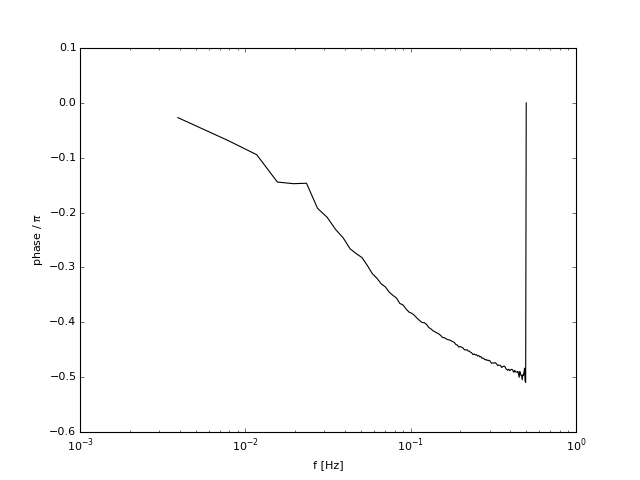

In [85]:
pxy,f=mlab.csd(x,y,NFFT=nfft,Fs=1./dt)
fig,ax=plt.subplots(1,1)
ax.semilogx(f,np.angle(pxy)/np.pi,'k')
ax.set_xlabel('f [Hz]')
ax.set_ylabel('phase / $\pi$')

So, this phase response is not linear, and thus this is a drawback of this particular filter. 

Finally, hopefully it is clear that four co-efficients makes this a very compact and fast filter.  As we saw above, to get to a $f_c=0.04$ we'd need a FIR filter that was $(K-1)/2=f_c T$, so $K=51$ is necessary to even start to get a good filter.  Here, the short filter length is an obvious advantage.

## Filter Cascades

Staying with our "poor" filter for a bit, there is a way to improve the frequency response without redesigning the filter.  That is to simply take the functional form above to a higher power:

$$|H(f)|^2 = \left(\frac{B^2}{w^2 + B^2}\right)^n $$

Running through the filter $n$ more times makes a sharper and sharper transition.  It also moves the roll-off point to lower frequencies.

<IPython.core.display.Javascript object>


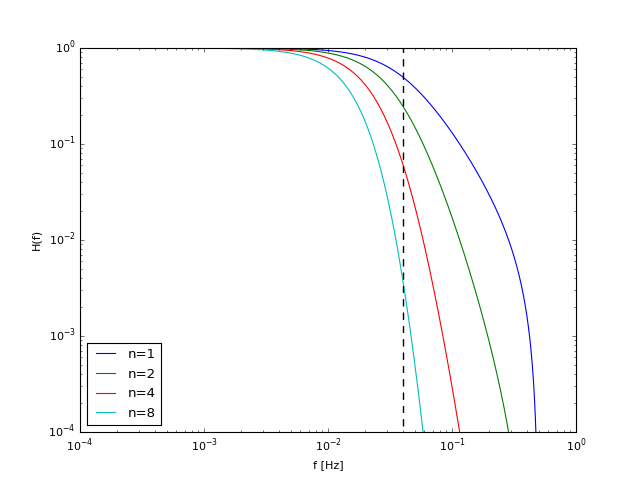

In [88]:
f=ff
fig,ax=plt.subplots(1,1)
for n in [1, 2, 4, 8]:
    H = (B**2/(w**2+B**2))**n
    ax.loglog(f,H,label='n=%d' % n)
    ax.plot(np.array([1.,1.])*fc,[2, 1e-4],'k--')
    ax.set_ylim((1e-4,1))
    ax.legend(loc=3)
    ax.set_xlabel('f [Hz]')
    ax.set_ylabel('H(f)')

We can correct for the offset in the roll-off frequency  by modifying $B = B_o n^{1/2}$:

<IPython.core.display.Javascript object>


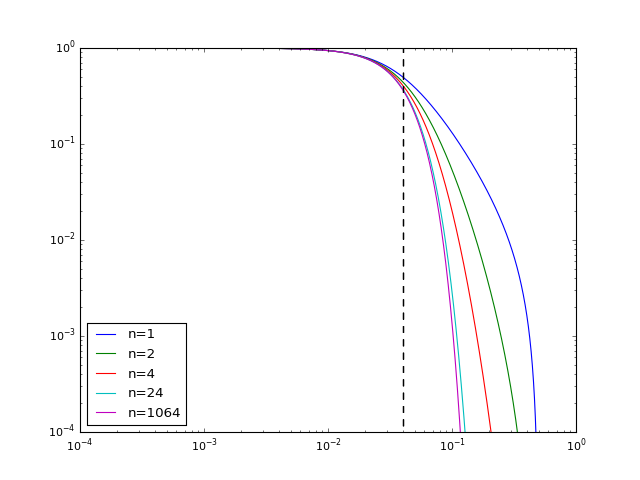

In [90]:
fig,ax=plt.subplots(1,1)
for n in [1, 2, 4, 24, 1064]:
    B = np.tan(np.pi*fc*dt)
    B = B*n**(0.5)
    H = (B**2/(w**2+B**2))**n
    ax.loglog(f,H,label='n=%d' % n)
    ax.plot(np.array([1.,1.])*fc,[2, 1e-4],'k--')
    ax.set_ylim((1e-4,1))
    ax.legend(loc=3)

In order to impliment this, we simply run the same filter n times (with $B=B_0n^{1/2}$).  Again, note the use of `lfilter` to filter the data using the co-efficients.

<IPython.core.display.Javascript object>


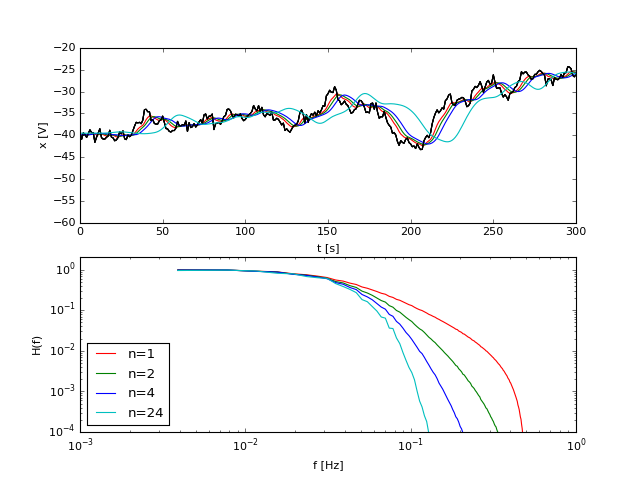

In [94]:
def compresponse(t,x,y,px,col0,col,n):
    # quick function to plot the responses since we will do this a lot:
    
    ax[0].plot(t,x,color=col0)
    ax[0].plot(t,y,color=col)
    ax[0].set_xlim((0,300))
    ax[0].set_ylim((-60,-20))
    ax[0].set_xlabel('t [s]')
    ax[0].set_ylabel('x [V]')
    
    py,f=mlab.psd(y,NFFT=nfft,Fs=1./dt)
    ax[1].loglog(f,py/px,color=col,label='n=%d' % n)
    ax[1].set_ylim((1e-4,2))
    ax[1].set_ylabel('H(f)')
    ax[1].set_xlabel('f [Hz]')

N=3000
dt=1.
t = np.arange(0.,N,dt)
fig,ax=plt.subplots(2,1)
    
np.random.seed(1234) # keep the random generator making the same random signal
x = np.cumsum(np.random.randn(N)) # red noise
nfft=256
px,f=mlab.psd(x-np.mean(x),NFFT=nfft,Fs=1./dt)
col = ['r','g','b','c']
num=0
for n in [1, 2, 4, 24]:
    B = np.tan(np.pi*fc*dt)*n**(0.5)
    b = [B,B]
    a = -1.*np.array([-1.-B,1.-B])
    y=1.0*x
    for ii in range(0,n):
        y = signal.lfilter(b,a,y)
    compresponse(t,x-np.mean(x),y-np.mean(y),px,'k',col[num],n)
    num=num+1
    
ax[1].legend(loc=3)

Aside from the obvious phase error (particularly evident for $n=24$), this "cascading" of the filter does what we want.  

## IIR Filter design

The filter above is pretty crude, but very amenable to analytic expression.  There is a whole arcana of filters, mostly carried over from the analog filter literature.  These filters typically involve making tradeoffs between passband ripples and the sharpness of the transition region.  Both can always be improved by higher order filters, which are derived by cascading known low-order filter designs.  There are two filter types of interest here: the "Butterworth" and the "Elliptical" filters.

### Butterworth Filter

Butterworth fitlers have excellent passband response at the expense of a wide transition region.  Their gain response is theoretically given by:

$$ |H(f)|^2 = \frac{1}{1 + \left(\frac{f}{f_c}\right)^n}$$

where $n$ is the number of "poles" in the filter.  More $n$ means a tighter transition region, at the expense of more filter co-efficients.

<IPython.core.display.Javascript object>


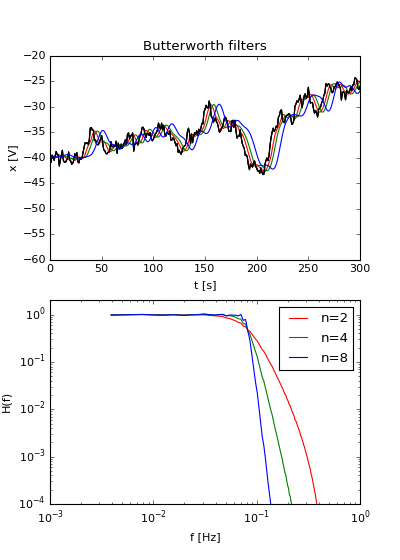

In [96]:
import scipy.signal as signal

num=0
fig,ax=plt.subplots(2,1,figsize=(5,7))
for n in [2,4,8]:
    b,a=signal.butter(n,fc*2.*2.)
    y = signal.lfilter(b,a,x)
    compresponse(t,x-np.mean(x),y-np.mean(y),px,'k',col[num],n)
    num=num+1
ax[1].legend()
#ax[0].set_ylim((0.1,2))
ax[0].plot(np.ones(2)*2.*fc,[0.1, 2.],'k--')
ax[0].set_title('Butterworth filters')

It is possible in both matlab and python to "design" the butterworth filter, i.e. determine the minimum order ($n$) that will achieve the desired shape.  The way this is done is to specify the highest frequency in the passband that we want to control the loss in dB, the lowest frequency that we want to have as part of the stop band, and then the amount of leakage we will allow in each.  

As an example, suppose we want to have a filter that has no more than 0.1 dB ($H(f)>10^{-0.1/20}=0.9892$) of attenuation below $f_p=0.07 Hz$, and at least 40 dB ($H(f)<10^{-40/20}<0.01$) of attenuation in the stop band above $f_s = 0.12 Hz$.  Then:

12
0.0813951279393


<IPython.core.display.Javascript object>


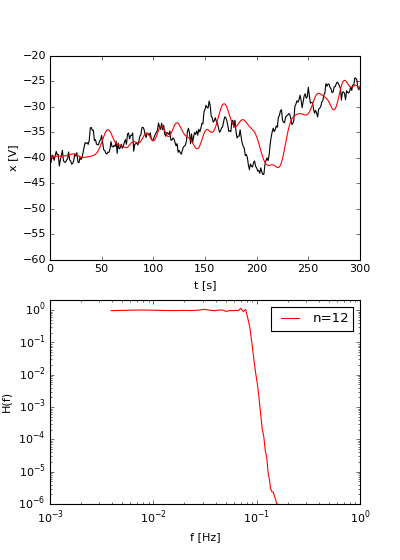

(1e-06, 2)

In [97]:
fp = 0.07
fs = 0.12
fNyq = 1./2./dt
n,fn=signal.buttord(fp/fNyq, fs/fNyq,.1, 40.)
print n
print fn*fNyq
b,a=signal.butter(n,fn)

y = signal.lfilter(b,a,x)
fig,ax=plt.subplots(2,1,figsize=(5,7))
compresponse(t,x-np.mean(x),y-np.mean(y),px,'k',col[0],n)
ax[1].legend()
ax[1].set_ylim([1e-6,2])

So `buttord` tells us that we need a 12-pole filter centered at 0.0814 Hz to get the passband characteristic we want.  Note that there is *still* a phase shift we should worry about.  

## Elliptical Filters

Elliptic fitlers are for the case when you are willing to have some passband ripple, in exchange for a sharp transition.  Here we specify the order, the allowed ripple in the passband, and how far down the stop band is:

5
0.07


<IPython.core.display.Javascript object>


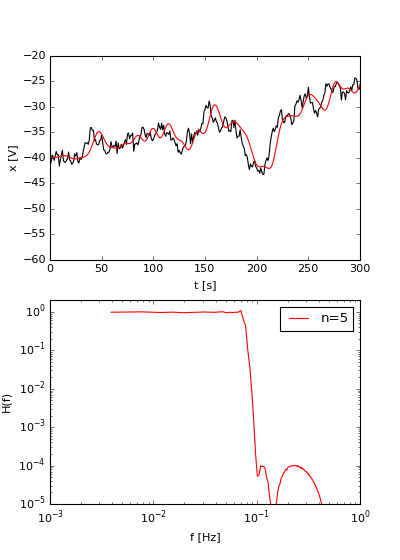

In [99]:
fp = 0.07
fs = 0.12
n,fn=signal.ellipord(fp/fNyq, fs/fNyq,.1, 40.)
print n
print fn/2.
b,a=signal.ellip(n,.1,40.,fn)
y = signal.lfilter(b,a,x)
fig,ax=plt.subplots(2,1,figsize=(5,7))
compresponse(t,x-np.mean(x),y-np.mean(y),px,'k',col[0],n)
ax[1].set_ylim((1e-5,2))
ax[1].legend()

Here we see that we get similar result to the Butterworth, but with only an order of 4, rather than 12.  The cost is the slight ripple in the passband.  We can actually suppress that relatively easily by adding a slightly higher order.  

Another advantage of the elliptical filter is the nearly linear frequency response in the passband:

<IPython.core.display.Javascript object>


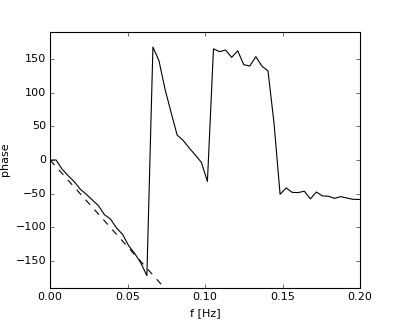

dt=-7.14 s time delay


In [103]:
pxy,f=mlab.csd(x,y,NFFT=nfft,Fs=1./dt)
fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.plot(f,np.angle(pxy)*180./np.pi,'k')
dtt = -1./0.07/2.
print 'dt=%1.2f s time delay' % dtt
ax.plot(f,f*2.*180*dtt,'k--')
ax.set_ylim((-190,190))
ax.set_xlim((0,0.2))
ax.set_xlabel('f [Hz]')
ax.set_ylabel('phase')

So, to correct the time offset, we need only shift the results of the filter.  

### Summary

In general, IIR filters like the butterworth or elliptical filters are much more compact and have better transition characteristics than FIR filters.  They are harder to design, but unless your application is very specialized, there are plenty of software packages out there to guide you in the design of these filters.  They have more non-linear phase response, though the phase response of the elliptic filter is generally pretty good.

A large caveat with IIR filters is that if the filter is poorly designed, the repsonse can go to infinity (and indeed that is where the name ìnfinite impuse response filters comes from).  Often a little experimentation is required to get a good filter response.

## Fixing the phase response: `filtfilt`

We can easily fix a linear phase repsonse of any filter by running any of the filters above twice.  One time forward, and the second time backwards.  This of course cannot be done in real-time, but is easy to do to recorded data using `filtfilt`:

<IPython.core.display.Javascript object>


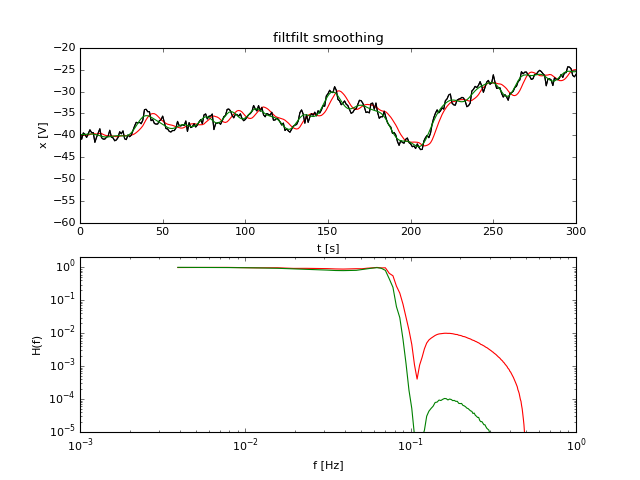

In [106]:
fig,ax=plt.subplots(2,1)
fp = 0.07
fs = 0.12
n,fn=signal.ellipord(fp*2., fs*2.,0.5, 20.)
b,a=signal.ellip(n,0.5,20,fn)
y = signal.lfilter(b,a,x)
compresponse(t,x-np.mean(x),y-np.mean(y),px,'k',col[0],n)
y = signal.filtfilt(b,a,x)
compresponse(t,x-np.mean(x),y-np.mean(y),px,'k',col[1],n)
ax[1].set_ylim([1e-5,2])
#legend()
ax[0].set_title('filtfilt smoothing')

Here we see that the `filtfilt` smoothing (green) has a sharper roll-off because the elliptic filter was applied twice.  It also no longer has the phase offset of the one-way filter (red).  

## High-pass and band-pass

All of the filters so far have been **low-pass** filters.  i.e. they remove high-frequency information and retain the low-frequency.  However, sometimes we want to have a **high-pass** filter which passes the high information and suppresses the low.  

In order to do this for FIR filters, its useful to consider the frequency response of the low-pass filter, and to remember that it actually is symmetric in positive and negative frequencies, though we have been just considering the positive frequencies.  So,

$$
H_L(m)=\begin{cases}
1 & |m|<M/2\\
0 & |m|>M/2
\end{cases}
$$

Now if we want to shift a function in frequency space, we convolve it with the delta function, so if we want to center the boxcar at $m_c$ and $-m_c$ instead of at $0$, then we say:

$$
H_{m_c}(m)=H_L(m)\star\delta(m_c) + H_L(m)\star\delta(-m_c)
$$


<IPython.core.display.Javascript object>


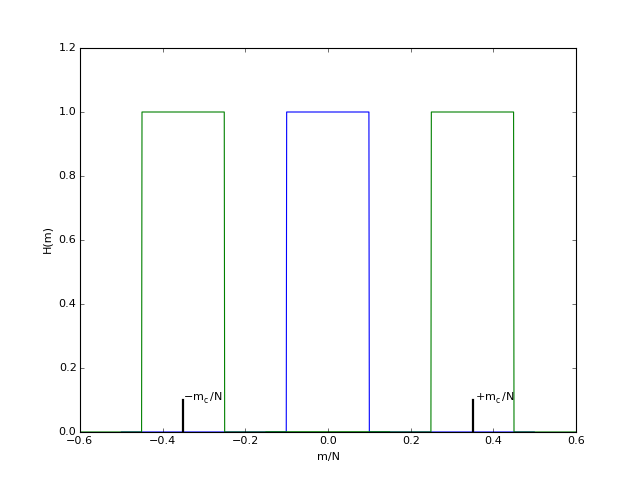

In [107]:
m=np.arange(-0.5,0.5,0.001)
mc = 0.35;M = 0.2;H_L=0.*m
H_L[np.abs(m)<M/2.]=1.
fig,ax=plt.subplots(1,1)
ax.plot(m,H_L);ax.plot(m+mc,H_L,'g');ax.plot(m-mc,H_L,'g')
ax.set_ylim([0.,1.2])
ax.set_xlim([-0.6,0.6])
ax.plot([-mc,-mc],[0,0.1],'k',linewidth=2)
ax.plot([mc,mc],[0,0.1],'k',linewidth=2)
ax.text(+mc,0.1,'$+m_c/N$');ax.text(-mc,0.1,'$-m_c/N$');ax.set_xlabel('m/N');ax.set_ylabel('H(m)')

We can transform $H_{m_c}(m)$ into the time domain by taking the inverse Fourier transform, which it is easy to see is given by:

$$ h(k)=2 h_L(k)\cos\left(\frac{2 m_c \pi k}{N} \right)$$

This will give a **band-pass** centered at frquency $\pm m_c$.  

Note that with this technique, we need to be careful that the passband does not overlap with the Nyquist frequency; in this case,  we are really just doing a high pass, in which case we do the following.

To get a **high-pass**, we simply shift to the Nyquist frequency, or $m_c=N$ so that the high-pass filter is given by:

$$ h_H(k)=h_L(k)\,\cos\left(\pi k\right)$$

$$ h_H(k)=\begin{cases}
h_L(k) & k\ \text{even}\\
-h_L(k) &k\ \text{odd}
\end{cases}$$



<IPython.core.display.Javascript object>


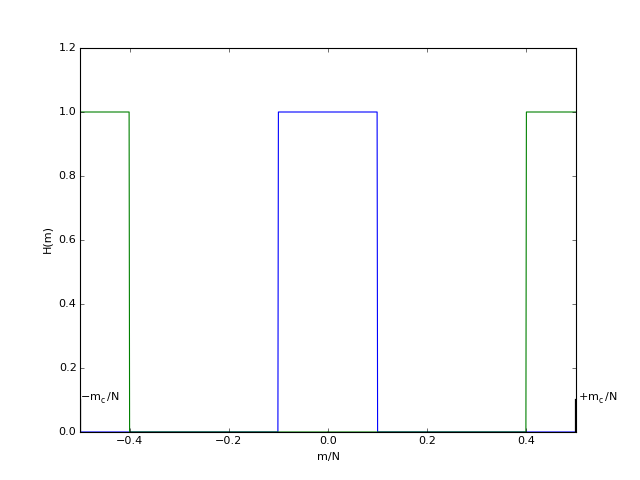

In [108]:
mc = 0.5;M = 0.2;H_L=0.*m
H_L[np.abs(m)<M/2.]=1.
fig,ax=plt.subplots(1,1)
ax.plot(m,H_L);ax.plot(m+mc,H_L,'g');ax.plot(m-mc,H_L,'g')
ax.set_ylim([0.,1.2]);ax.set_xlim([-0.5,0.5])
ax.plot([-mc,-mc],[0,0.1],'k',linewidth=2)
ax.plot([mc,mc],[0,0.1],'k',linewidth=2)
ax.text(+mc,0.1,'$+m_c/N$');ax.text(-mc,0.1,'$-m_c/N$');ax.set_xlabel('m/N');ax.set_ylabel('H(m)')

A simple technique for devising a band pass is to first run a low-pass and then run a high-pass filter,  leaving the frequencies you want to keep in the passbands of the two filters.